# HEADSS2 Demo
This notebook goes through the key functionality of HEADSS2. For a more detailed background as well as the API reference, see the official [documentation](https://headss2.readthedocs.io/en/latest/).

## Spark setup
HEADSS2 0.2.0 onwards relies on Spark for processing.

Note that `graphframes` is a mandatory Java JAR dependency.

If you do not have a SparkSession available in your environment already, you can create one:

In [1]:
from pyspark.sql import SparkSession


spark = (
    SparkSession.builder
        .appName("test-regions")
        .config("spark.driver.memory", "16g")        # or more, e.g. 16g
        .config("spark.executor.memory", "8g")      # increase executor memory as well
        .config("spark.executor.cores", "4")        # keep cores as you want
        .getOrCreate()
)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/17 16:39:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Example datasets
HEADSS2 comes with ten example datasets


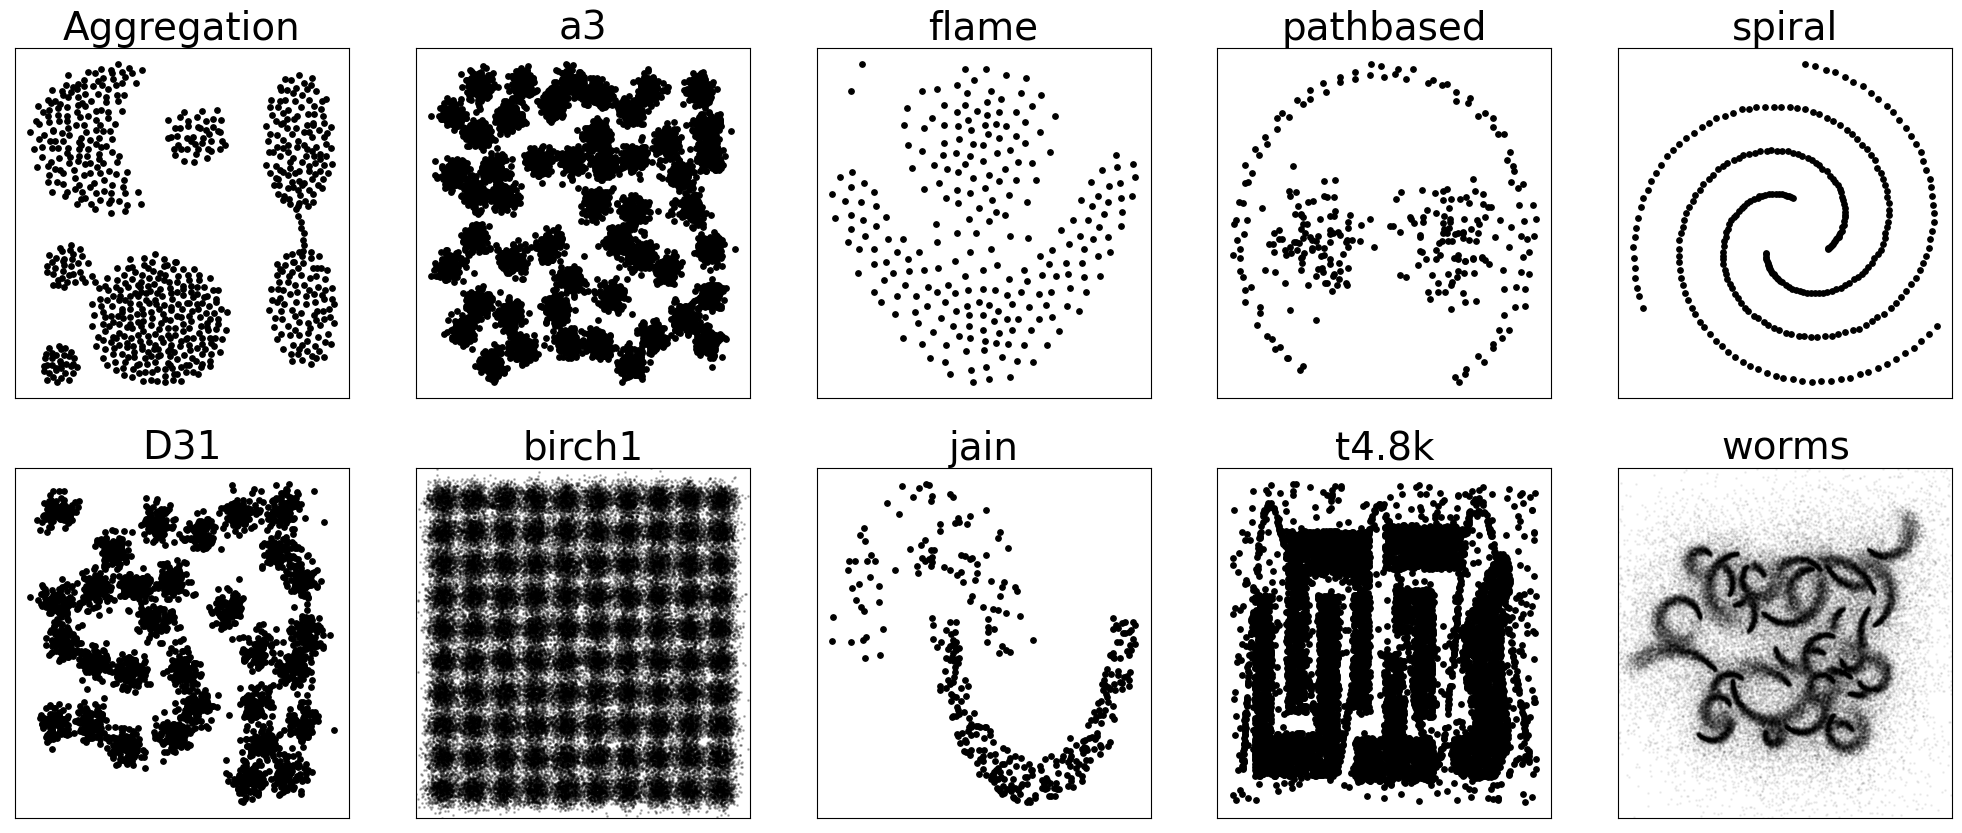

In [2]:
import base64
from IPython.display import HTML

with open("datasets.png", "rb") as image_file:
    encoded = base64.b64encode(image_file.read()).decode('utf-8')

HTML(f'<img src="data:image/png;base64,{encoded}" />')


The `dataset(name)` function retrieves each dataset as a Pandas dataframe. 

In [3]:
from headss2 import dataset
dataset("D31")

,x,y
0,25.0514,5.7475
1,26.6614,7.3414
2,25.2653,6.2466
3,25.2285,4.7447
4,25.7529,5.1564
...,...,...
3095,5.1380,16.6150
3096,5.7360,16.9991
3097,5.2760,17.2475
3098,6.4444,16.2033


Note the use of an underscore instead of a full stop in the name of `t4_8k`

In [4]:
t4_8k = dataset("t4_8k")
t4_8k

,x,y
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000
...,...,...
7995,442.420990,303.721985
7996,495.451996,288.502991
7997,267.605011,141.725006
7998,238.358002,252.729996


## Simplified API
HEADSS2 0.2.0 comes with an optional simplified API to make regions, cluster data, stitch regions, and merge clusters in fewer lines of code. This is more similar to the original HEADSS implementation. The option to call individual modules remains.

In [5]:
from headss2 import HEADSS2

In [6]:
headss_obj = HEADSS2(
    n = 2,
    min_cluster_size=10,
    min_samples=10,
    allow_single_cluster=False,
    clustering_method="eom",
    drop_unclustered=True,
    per_cluster_overlap_threshold=0.1,
    combined_overlap_threshold=0.5,
    spark_session=spark
)

headss_obj.fit(t4_8k, ["x", "y"])

In [7]:
headss_obj.merged.show()

[Stage 775:==================================================> (756 + 28) / 784]

+-------+-------+------+-------+
|      x|      y|region|cluster|
+-------+-------+------+-------+
| 68.602|102.492|     0|    0_3|
|300.989| 46.555|     0|    0_0|
|110.171| 55.648|     0|    0_3|
|118.856| 47.446|     0|    0_3|
|143.376|117.738|     0|    0_4|
|204.207| 133.41|     0|    0_3|
|  78.26|139.327|     0|    0_3|
| 68.434| 59.125|     0|    0_3|
| 84.023| 90.084|     0|    0_3|
|214.477| 63.822|     0|    0_3|
|163.141| 66.302|     0|    0_3|
| 63.076|  78.06|     0|    0_3|
|319.376| 65.832|     0|    0_0|
| 320.43| 57.284|     0|    0_0|
| 77.562|152.847|     0|    0_3|
| 79.098|128.405|     0|    0_3|
| 76.775| 83.792|     0|    0_3|
| 88.132| 84.512|     0|    0_3|
|201.808| 97.972|     0|    0_3|
|289.504|114.581|     0|    0_1|
+-------+-------+------+-------+
only showing top 20 rows


## Making regions

In [8]:
a3 = dataset("a3")

In [9]:
from headss2 import make_regions

In [10]:
regs_a3 = make_regions(df = a3, 
             n = 2,   # number of cuts in base layer
             cluster_columns = ['x', 'y'],
             spark_session=spark)  # columns to be used for splitting

`make_regions` returns a `Regions` object, with two attributes: `split_data` (dataset partitioned into regions) and `split_regions` (summary statistics about each region)

In [11]:
regs_a3.split_data

DataFrame[x: bigint, y: bigint, region: bigint]

In [12]:
regs_a3.split_regions

,region,x_min,x_max,y_min,y_max
0,0,0.00,32767.50,976.0,32559.0
1,1,0.00,32767.50,16767.5,48350.5
2,2,0.00,32767.50,32559.0,64142.0
3,3,16383.75,49151.25,976.0,32559.0
4,4,16383.75,49151.25,16767.5,48350.5
5,5,16383.75,49151.25,32559.0,64142.0
6,6,32767.50,65535.00,976.0,32559.0
7,7,32767.50,65535.00,16767.5,48350.5
8,8,32767.50,65535.00,32559.0,64142.0


## Clustering with HDBSCAN

This module is just a wrapper around HDBSCAN, so to select appropriate parameters for your dataset, please refer to the [HDBSCAN documentation](https://hdbscan.readthedocs.io/en/latest/index.html).

In [13]:
from headss2 import cluster
clustered_a3 = cluster(split_data=regs_a3.split_data,
        min_cluster_size=10,
        min_samples=None,
        clustering_method='eom',
        allow_single_cluster=False,
        cluster_columns=['x', 'y'])

In [14]:
clustered_a3.show()

[Stage 784:==================================================> (763 + 21) / 784]

+-------+-------+------+-------+
|      x|      y|region|cluster|
+-------+-------+------+-------+
| 8960.0|29349.0|     0|    0_1|
| 9566.0|30666.0|     0|    0_1|
|10002.0|29085.0|     0|    0_1|
| 9051.0|28004.0|     0|    0_1|
| 8262.0|29745.0|     0|    0_1|
| 9612.0|30786.0|     0|    0_1|
| 8479.0|29223.0|     0|    0_1|
| 9685.0|31428.0|     0|    0_1|
|10844.0|29711.0|     0|    0_1|
|10599.0|28555.0|     0|    0_1|
| 9774.0|29756.0|     0|    0_1|
| 8628.0|26811.0|     0|    0_1|
|10022.0|30615.0|     0|    0_1|
| 9438.0|29445.0|     0|    0_1|
|12814.0|27360.0|     0|    0_1|
| 9850.0|30329.0|     0|    0_1|
|10836.0|28222.0|     0|    0_1|
|10426.0|29327.0|     0|    0_1|
|10304.0|29461.0|     0|    0_1|
| 8230.0|28746.0|     0|    0_1|
+-------+-------+------+-------+
only showing top 20 rows


## Stitching
Stitching refers to the process of joining the regions that have each been processed in parallel. There are no parameters for users to fine tune at this stage

In [15]:
from headss2 import stitch
stitch(clustered=clustered_a3,
       cluster_columns=['x', 'y'],
       stitch_regions=regs_a3.stitch_regions)

DataFrame[x: float, y: float, region: int, cluster: string]

## Merging

Finally, HEADSS2 can identify overlapping clusters and merge them to improve results.

`a3` does not require merging, so we are going to use `t4_8k` for this.

First, we'll need to make regions, cluster, and stitch the data as before:

In [16]:
t4_8k = dataset("t4_8k")

regs_t4_8k = make_regions(df=t4_8k, n=2, cluster_columns=['x', 'y'], spark_session=spark)

clustered_t4_8k = cluster(split_data=regs_t4_8k.split_data,
                          cluster_columns=['x', 'y'],
                          min_cluster_size=30,
                          min_samples=10,
                          clustering_method='eom',
                          allow_single_cluster=False)

stitched_t4_8k = stitch(clustered=clustered_t4_8k,
                        cluster_columns=['x', 'y'],
                        stitch_regions=regs_t4_8k.stitch_regions)

Then perform the merging. See the [documentation](https://headss2.readthedocs.io/en/latest/) for details on these parameters.

In [17]:
from headss2 import merge_clusters

merged_t4_8k = merge_clusters(
    clustered=stitched_t4_8k,
    cluster_columns=["x", "y"],
    min_n_overlap=10,
    per_cluster_overlap_threshold=0.1,
    combined_overlap_threshold=0.5,
)

#### Before merging:

<Axes: xlabel='x', ylabel='y'>

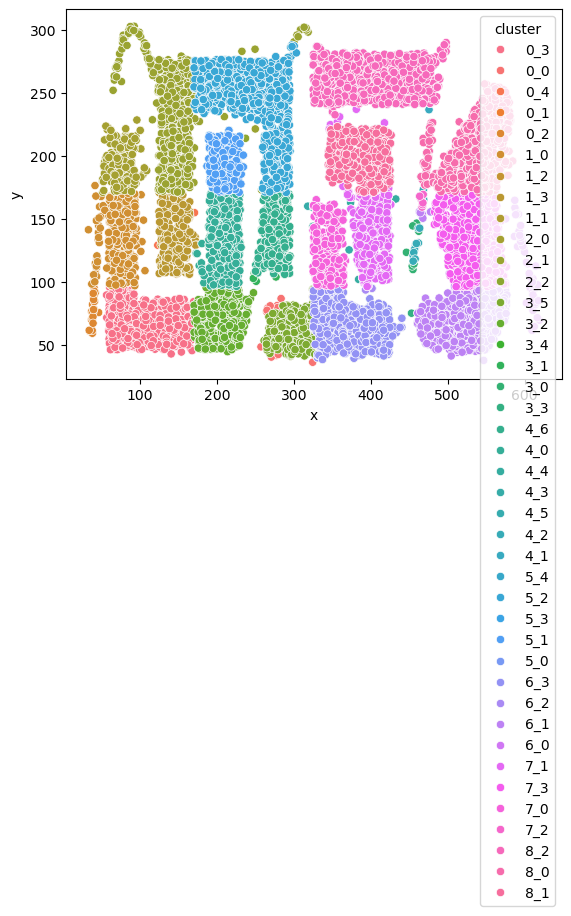

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
clustered_pd = clustered_t4_8k.toPandas()
sns.scatterplot(x=clustered_pd.x, y=clustered_pd.y, hue= clustered_pd.cluster)

#### With merging:

<Axes: xlabel='x', ylabel='y'>

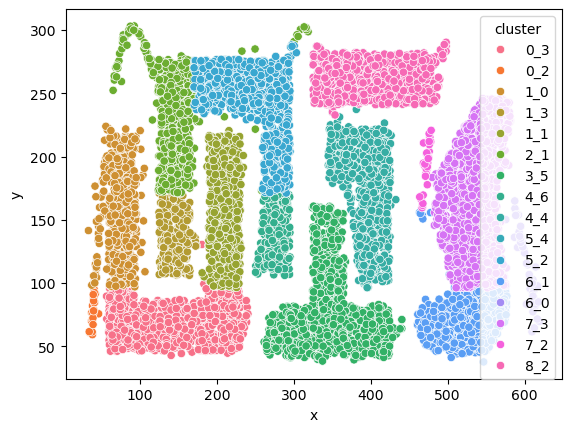

In [19]:
pd_merged = merged_t4_8k.toPandas()
sns.scatterplot(x=pd_merged.x, y=pd_merged.y, hue= pd_merged.cluster)

In [20]:
aggregation = dataset("Aggregation")

In [21]:
headss_obj = HEADSS2(
    n = 2,
    min_cluster_size=10,
    min_samples=10,
    allow_single_cluster=False,
    clustering_method="eom",
    drop_unclustered=True,
    per_cluster_overlap_threshold=0.1,
    combined_overlap_threshold=0.9,
    min_n_overlap=3,
    spark_session=spark,
    merge_clusters=False
)

headss_obj.fit(aggregation, ["x", "y"])

In [22]:
unmerged = headss_obj.stitched.toPandas()

<Axes: xlabel='x', ylabel='y'>

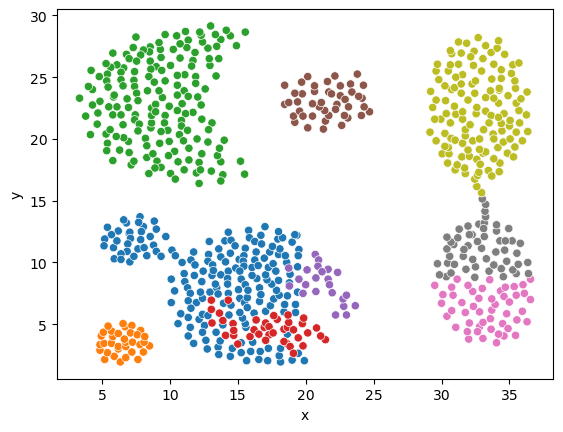

In [23]:
sns.scatterplot(x=unmerged.x, y=unmerged.y, hue= unmerged.cluster, legend=False)

In [24]:
len(unmerged)

896

In [25]:
merged = merge_clusters(
    clustered=headss_obj.stitched,
    cluster_columns=["x", "y"],
    min_n_overlap=3,
    per_cluster_overlap_threshold=0.9,
    combined_overlap_threshold=0.1,
).toPandas()

<Axes: xlabel='x', ylabel='y'>

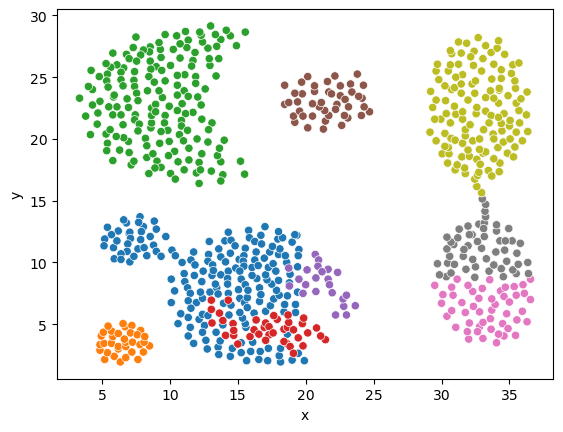

In [26]:
sns.scatterplot(x=merged.x, y=merged.y, hue= merged.cluster, legend=False)

In [27]:
from headss2 import merging

In [28]:
bounds = merging._get_cluster_bounds(clustered = headss_obj.stitched,
                            cluster_columns=["x", "y"])
bounds.show()

[Stage 1129:=================================================> (767 + 17) / 784]

+-------+-----+-----+-----+-----+
|cluster|x_min|y_min|x_max|y_max|
+-------+-----+-----+-----+-----+
|    7_2|29.15|  8.8| 36.4| 22.3|
|    8_1|29.15|15.65|36.35| 28.2|
|    0_0| 4.85| 1.95|  8.5| 5.05|
|    0_1| 5.15| 1.95| 19.9| 13.7|
|    5_0|18.45| 20.8| 24.7|25.25|
|    2_1| 3.35| 16.4|15.55|29.15|
|    3_0|13.05| 2.65|21.45| 6.95|
|    3_1|18.75| 5.75|23.65|10.65|
|    6_1| 29.5|  3.5|36.55|15.15|
+-------+-----+-----+-----+-----+



In [29]:
from headss2 import clustering

In [30]:
agg_clustered = clustering.cluster(headss_obj.regions.split_data, min_cluster_size=20, min_samples=20, allow_single_cluster=False, clustering_method="leaf", cluster_columns=["x", "y"])

In [31]:
agg_clustered.show()

[Stage 1140:=================================================> (756 + 28) / 784]

+----+-----+------+-------+
|   x|    y|region|cluster|
+----+-----+------+-------+
| 9.0| 12.7|     0|    0_2|
|8.05| 12.9|     0|    0_2|
| 7.7|13.25|     0|    0_2|
| 6.8| 13.2|     0|    0_2|
| 6.2|12.55|     0|    0_2|
| 5.7|12.25|     0|    0_2|
|5.85| 11.2|     0|    0_2|
| 6.1|11.75|     0|    0_2|
| 7.0|12.35|     0|    0_2|
|7.05|12.45|     0|    0_2|
| 7.9| 12.5|     0|    0_2|
|8.55| 12.1|     0|    0_2|
|7.85|11.85|     0|    0_2|
| 7.1|11.95|     0|    0_2|
| 6.9| 11.5|     0|    0_2|
|6.85| 10.9|     0|    0_2|
| 6.4| 10.7|     0|    0_2|
|7.35| 10.5|     0|    0_2|
|7.65| 11.1|     0|    0_2|
| 8.1| 11.2|     0|    0_2|
+----+-----+------+-------+
only showing top 20 rows


In [32]:
agg_clustered.count()

25/09/17 17:10:17 ERROR Executor: Exception in task 0.0 in stage 1145.0 (TID 166142)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 2036, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 564, in dump_stream
    return ArrowStreamSerializer.dump_stream(self, init_stream_yield_batches(), stream)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 115, in dump_stream
    for batch in iterator:
                 ^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspa

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 2044, in main
    process()
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 2036, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 564, in dump_stream
    return ArrowStreamSerializer.dump_stream(self, init_stream_yield_batches(), stream)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 115, in dump_stream
    for batch in iterator:
                 ^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py", line 557, in init_stream_yield_batches
    for series in iterator:
                  ^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 1751, in mapper
    return f(keys, vals)
           ^^^^^^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 534, in <lambda>
    return lambda k, v: [(wrapped(k, v), arrow_return_type)]
                          ^^^^^^^^^^^^^
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 527, in wrapped
    verify_pandas_result(
  File "/home/sharnqvi/spark-4.0.1-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 313, in verify_pandas_result
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [RESULT_LENGTH_MISMATCH_FOR_PANDAS_UDF] Number of columns of the returned pandas.DataFrame doesn't match specified schema. Expected: 4 Actual: 5


In [ ]:
agg_clustered_pd = agg_clustered.toPandas()
agg_clustered_pd.head()
sns.scatterplot(x=agg_clustered_pd.x, y=agg_clustered_pd.y, hue=agg_clustered_pd.cluster, legend=False)